In [1]:
import awkward as ak
import hist
import jax
import matplotlib.pyplot as plt
import numpy as np
import uproot
import vector
import urllib

vector.register_awkward()
ak.jax.register_and_check()

In [3]:
ttbar_file = "https://github.com/scikit-hep/scikit-hep-testdata/"\
    "raw/main/src/skhep_testdata/data/nanoAOD_2015_CMS_Open_Data_ttbar.root"

def correct_jets(jets, alpha):
    """perform jet energy calibration with nuisance parameter alpha"""
    jets = ak.Array(jets)
    new_pt = jets["pt"] + 25*alpha
    jets["pt"] = new_pt
    return jets

def get_mass(jets):
    """get dijet mass using system of first two jets"""
    return (jets[:, 0] + jets[:, 1]).mass  # returning (jets[:, 0]).mass causes a different errror with jax

def pipeline(jets, a):
    """analysis pipeline: calculate mean of dijet masses"""
    return np.mean(get_mass(correct_jets(jets, a)))


with uproot.open(ttbar_file) as f:
    arr = f["Events"].arrays(["Jet_pt","Jet_eta", "Jet_phi", "Jet_mass"])
    evtfilter = ak.num(arr["Jet_pt"]) >= 2
    jets = ak.zip(dict(zip(["pt","eta", "phi", "mass"], ak.unzip(arr))), with_name="Momentum4D")[evtfilter]
    jets = ak.to_backend(jets, "jax")

    
# scan the analysis pipeline for various nuisance parameter values
np_vals = np.linspace(-5, 5, 20) 
vals_and_grads = np.array([jax.value_and_grad(pipeline, argnums=1)(jets, a) for a in np_vals])

mass_means = vals_and_grads[:, 0]
grads = vals_and_grads[:, 1]

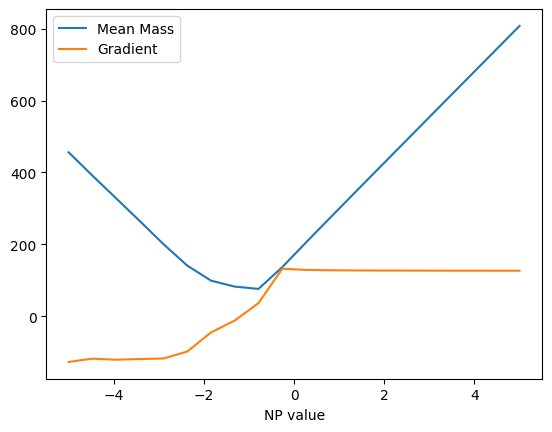

In [8]:
fig, ax = plt.subplots()
ax.plot(np_vals, mass_means, label='Mean Mass')
ax.plot(np_vals, grads, label='Gradient')
ax.set_xlabel("NP value")
ax.set_ylabel("")
ax.legend()

Let's use gradient descent

In [ ]:
steps = 50
c0 = -2. # initial position
alpha = 0.005 # step size

c0s, vals = [], []

for i in range(steps):
    val, grad = jax.value_and_grad(pipeline, argnums=1)(jets, c0)
    if i % 10 == 0:
        print("current position is", c0, "and the gradient is", grad)
    c0s.append(c0)
    vals.append(val)
    c0 = c0 - alpha * grad

print("final position is", c0)

# plt.plot(cuts_smooth, significances_smooth, c="C3")
opt_range = np.max(c0s) - np.min(c0s)
inter_steps = np.linspace(np.min(c0s) - opt_range/4, np.max(c0s) + opt_range/4, 50)
plt.plot(inter_steps, [pipeline(jets, x) for x in inter_steps])
plt.plot(c0s, vals, "o", c="C4", label="Steps taken by gradient descent")
plt.xlabel("NP value")
plt.ylabel("Mean mass")

current position is -2.0 and the gradient is -77.54979
current position is -0.8747784 and the gradient is 0.25869423
current position is -0.8769495 and the gradient is -0.00016912818


Our input file is tiny. The following cell could be used instead to process 500 MB of data.

In [13]:
import os

ttbar_file = "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/"\
    "TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_"\
    "mcRun2_asymptotic_v12_ext4-v1_80000_0007.root"

# download for subsequent use
local_file_name = "ttbar.root"
if not os.path.exists(local_file_name):
    urllib.request.urlretrieve(ttbar_file, filename=local_file_name)

KeyboardInterrupt: 